# Catalog-based forecast tutorial - UCERF3 Landers

In this tutorial we will look at an example of a catalog-based forecast.  

Our goal is to test whether the forecast number of earthquakes from a UCERF3-ETAS aftershock model is consistent with observations for the 1992 Landers sequence.
The PyCSEP package has been designed so that the order of the steps that we take to do this is very similar to that for the gridded forecasts with a few differences. This tutorial aims to familiarise the user with some of the differences involved and further understanding of how these new CSEP tests are carried out.

Full documentation of the package can be found [here](https://docs.cseptesting.org/) and any issues can be reported on the [PyCSEP Github page](https://github.com/SCECcode/pycsep). The theory behind catalog-based evaluations can be found [here](https://docs.cseptesting.org/getting_started/theory.html#catalog-based-forecast-tests) and the routines [here](https://docs.cseptesting.org/concepts/evaluations.html#catalog-based-forecast-evaluations). 

In [1]:
# Most of the core functionality can be imported from the top-level csep package. 
import csep

# Or you could import directly from submodules, like csep.core or csep.utils submodules.
from csep.core import regions, catalog_evaluations
from csep.core import poisson_evaluations as poisson
from csep.utils import datasets, time_utils, comcat, plots

import numpy
import cartopy

## 1. Load forecast

Forecasts should define a time horizon in which they are valid. The choice is flexible for catalog-based forecasts, because the catalogs can be filtered to accommodate multiple end-times. Conceptually, these should be separate forecasts.  

For catalog-based forecasts, we need to explicitly compute bin-wise rates. Before we can compute the bin-wise rates we need to define a spatial region and a set of magnitude bin edges. The magnitude bin edges # are the lower bound (inclusive) except for the last bin, which is treated as extending to infinity. We can bind these # to the forecast object.  

The spatial region should also be explicitly defined, in contrast to the gridded forecast where this is extracted from the data. In this example, we use the RELM polygon included in the package.


In [16]:
### Set up model parameters

# Start and end time
start_time = time_utils.strptime_to_utc_datetime("1992-06-28 11:57:34.14")
end_time = time_utils.strptime_to_utc_datetime("1992-07-28 11:57:34.14")

# Magnitude bins properties
min_mw = 4.95
max_mw = 8.95
dmw = 0.1

# Create space and magnitude regions. The forecast is already filtered in space and magnitude
magnitudes = regions.magnitude_bins(min_mw, max_mw, dmw)
region = regions.california_relm_region()

# Bind region information to the forecast (this will be used for binning of the catalogs)

space_magnitude_region = regions.create_space_magnitude_region(region, magnitudes)


To reduce the file size of this example, we’ve already pre-filtered the catalogs to the appropriate magnitudes and spatial locations. The format of catalogs and catalog-based forecasts is similar, with two extra columns in forecasts to represent the synthetic catalog id or the event id.


```
lon	        lat	        mag 	time_string	                depth	    catalog_id	event_id(optional)
-124.56793	40.419548	5.65	1992-07-10T19:10:07.057000	18.083824	0	
-124.56	    40.4	    6.69	1992-08-30T16:44:54.183000	21.0    	0	
-124.319466	40.21936	5.15	1992-08-30T21:14:55.449000	6.1641793	0
...
-116.36257	33.96388	5.25	1992-09-11T14:57:55.473000	0.25818658	1	
-121.804115	35.214355	4.95	1992-11-15T13:46:20.408000	4.7234006	1
...	
```

 The forecast is loaded simply as: 

In [17]:
forecast = csep.load_catalog_forecast('ucerf3-landers.csv',
                                      start_time = start_time,
                                      end_time = end_time,
                                      region = space_magnitude_region)


The original forecast was computed for 1 year following the start date, so we still need to filter the forecast in time. We can do this by passing a list of filtering arguments to the forecast or updating the class.

In [18]:
forecast.filters = [f'origin_time >= {forecast.start_epoch}', f'origin_time < {forecast.end_epoch}']

The `csep.core.forecasts.CatalogForecast` provides a method to compute the expected number of events in spatial cells. This requires a region with magnitude information.

In [19]:
# Assign filters to forecast (in this case time)
expected_rates = forecast.get_expected_rates(verbose=True)

Processed 1 catalogs in 0.002 seconds
Processed 2 catalogs in 0.017 seconds
Processed 3 catalogs in 0.021 seconds
Processed 4 catalogs in 0.033 seconds
Processed 5 catalogs in 0.046 seconds
Processed 6 catalogs in 0.049 seconds
Processed 7 catalogs in 0.053 seconds
Processed 8 catalogs in 0.068 seconds
Processed 9 catalogs in 0.075 seconds
Processed 10 catalogs in 0.078 seconds
Processed 20 catalogs in 0.099 seconds
Processed 30 catalogs in 0.162 seconds
Processed 40 catalogs in 0.208 seconds
Processed 50 catalogs in 0.230 seconds
Processed 60 catalogs in 0.253 seconds
Processed 70 catalogs in 0.282 seconds
Processed 80 catalogs in 0.314 seconds
Processed 90 catalogs in 0.339 seconds
Processed 100 catalogs in 0.364 seconds
Processed 200 catalogs in 0.508 seconds
Processed 300 catalogs in 0.612 seconds
Processed 400 catalogs in 0.714 seconds
Processed 500 catalogs in 0.866 seconds
Processed 600 catalogs in 0.967 seconds
Processed 700 catalogs in 1.076 seconds
Processed 800 catalogs in 1

The expected rates can now be plotted in a similar manner to the gridded forecast plots. Again, we can specify plot arguments as we did for the gridded forecasts.

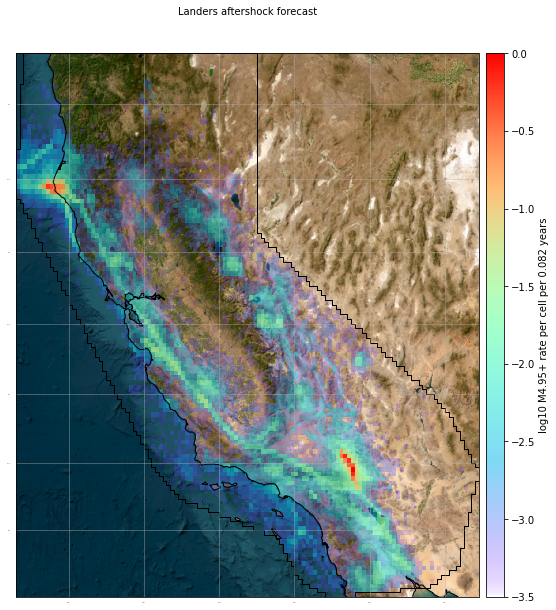

In [6]:
args_forecast = {'title': 'Landers aftershock forecast',
                 'grid_labels': True,
                 'basemap': 'ESRI_imagery',
                 'cmap': 'rainbow',
                 'alpha_exp': 0.5,
                 'projection': cartopy.crs.Mercator(),
                 'clim':[-3.5, 0]}

ax = expected_rates.plot(plot_args = args_forecast)

## 2. Filter evaluation catalog

In this example we use the `csep.query_comcat` function to obtain a catalog directly from [ComCat](https://earthquake.usgs.gov/data/comcat/). We need to filter the ComCat catalog to be consistent with the forecast. This can be done either through the ComCat API or using catalog filtering strings (see the gridded forecast example). Here we’ll use the Comcat API to make the data access quicker for this example. We still need to filter the observed catalog in space though.


In [20]:
# Obtain Comcat catalog and filter to region.
comcat_catalog = csep.query_comcat(start_time, end_time, min_magnitude=forecast.min_magnitude)

# Filter observed catalog using the same region as the forecast
comcat_catalog = comcat_catalog.filter_spatial(forecast.region)


Fetched ComCat catalog in 1.140394926071167 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 1992-06-28 11:57:34.130000+00:00
End Date: 1992-07-24 18:14:36.250000+00:00
Min Latitude: 33.901 and Max Latitude: 36.705
Min Longitude: -118.067 and Max Longitude: -116.285
Min Magnitude: 4.95
Found 20 events in the ComCat catalog.


## 3. Plot the catalog
The catalog can be plotted easily using the plot function. 


<GeoAxes: >

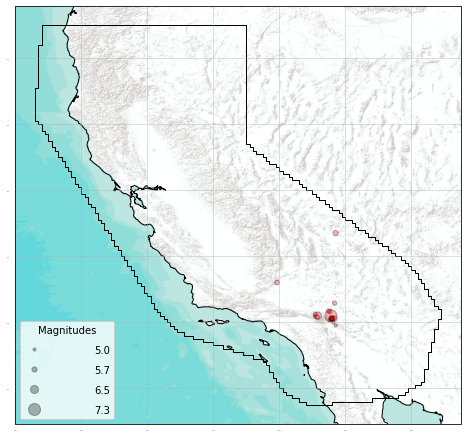

In [8]:
comcat_catalog.plot()

* Let's try changing some plot arguments by looking at the docs

## 4. Composite plot

Let's do a multiple plot, that includes the forecast expected rates and the observed catalog.
* We must first create a forecast plot, which returns a matplotlib.pyplot.ax object.
* This ax object should be passed to catalog.plot() as argument. 
* The plot order could be reversed, depending which layer is wanted above

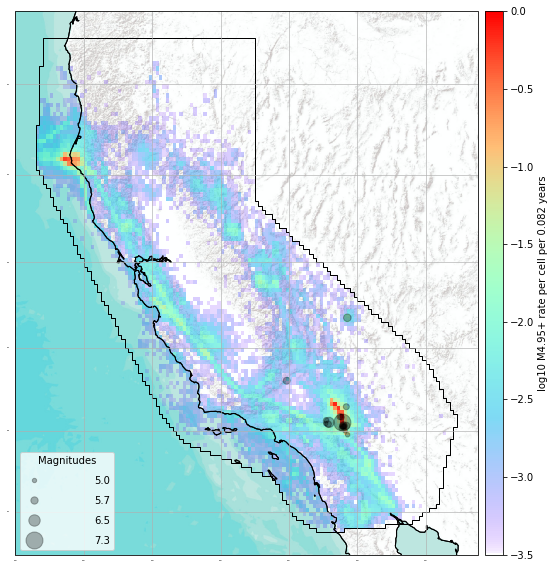

In [9]:
args_catalog = {'basemap': 'ESRI_terrain',
                'markercolor': 'black',
                'markersize': 4}
ax_1 = expected_rates.plot(plot_args=args_forecast)
ax_2 = comcat_catalog.plot(ax=ax_1, plot_args=args_catalog)


## 4. Perform a test 

Now that we have a forecast and evaluation catalog, tests can be easily applied in a similar way as with gridded forecasts. For example, we can perform the Number test on the catalog based forecast using the observed catalog we obtained from Comcat.

Processed 1 catalogs in 4.076957702636719e-05 seconds
Processed 2 catalogs in 0.0009739398956298828 seconds
Processed 3 catalogs in 0.0012950897216796875 seconds
Processed 4 catalogs in 0.003878355026245117 seconds
Processed 5 catalogs in 0.004499673843383789 seconds
Processed 6 catalogs in 0.004938602447509766 seconds
Processed 7 catalogs in 0.005380868911743164 seconds
Processed 8 catalogs in 0.005820512771606445 seconds
Processed 9 catalogs in 0.006377458572387695 seconds
Processed 10 catalogs in 0.006694316864013672 seconds
Processed 20 catalogs in 0.007211208343505859 seconds
Processed 30 catalogs in 0.007516384124755859 seconds
Processed 40 catalogs in 0.007796525955200195 seconds
Processed 50 catalogs in 0.008081674575805664 seconds
Processed 60 catalogs in 0.008374452590942383 seconds
Processed 70 catalogs in 0.00866389274597168 seconds
Processed 80 catalogs in 0.00893402099609375 seconds
Processed 90 catalogs in 0.00928187370300293 seconds
Processed 100 catalogs in 0.009864807

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


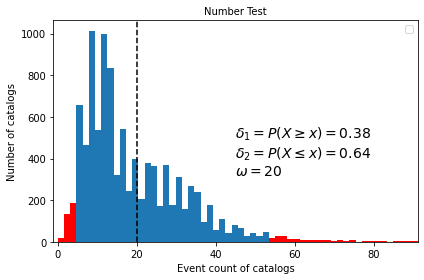

In [21]:
number_test_result = catalog_evaluations.number_test(forecast, comcat_catalog)
ax = number_test_result.plot()

We can also quickly perform a spatial test

Processed 1 catalogs in 0.0003235340118408203 seconds
Processed 2 catalogs in 0.004696846008300781 seconds
Processed 3 catalogs in 0.005892276763916016 seconds
Processed 4 catalogs in 0.00830078125 seconds
Processed 5 catalogs in 0.00924992561340332 seconds
Processed 6 catalogs in 0.011036396026611328 seconds
Processed 7 catalogs in 0.012258291244506836 seconds
Processed 8 catalogs in 0.017926931381225586 seconds
Processed 9 catalogs in 0.02490401268005371 seconds
Processed 10 catalogs in 0.028490304946899414 seconds
Processed 20 catalogs in 0.03180742263793945 seconds
Processed 30 catalogs in 0.0349423885345459 seconds
Processed 40 catalogs in 0.03802680969238281 seconds
Processed 50 catalogs in 0.04160928726196289 seconds
Processed 60 catalogs in 0.04400062561035156 seconds
Processed 70 catalogs in 0.04601240158081055 seconds
Processed 80 catalogs in 0.0482630729675293 seconds
Processed 90 catalogs in 0.051061391830444336 seconds
Processed 100 catalogs in 0.05938386917114258 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


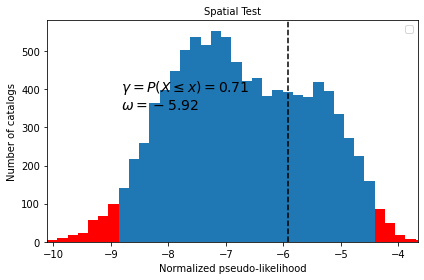

In [22]:
spatial_test_result = catalog_evaluations.spatial_test(forecast, comcat_catalog)
ax = spatial_test_result.plot()

### Questions for the reader

How should the above figure be interpreted? What does this test result tell you about the forecast?
How well does this model perform spatially?